<a href="https://colab.research.google.com/github/durml91/Public-share/blob/main/Basic_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import jax.numpy as jnp
import jax
from jax.experimental.host_callback import id_print
import matplotlib.pyplot as plt
from jax.lax import scan
from jax import grad, jit, vmap
import jax.random as  jr
from functools import partial
rng = jr.PRNGKey(2023)

import scipy

import seaborn as sns
sns.set_style("darkgrid")
cm = sns.color_palette("mako_r", as_cmap=True)

In [30]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [31]:
def sample_circle(J):
    
    alphas = jnp.linspace(0, 2*jnp.pi*(1-1/J), J)
    xs = jnp.cos(alphas)
    ys = jnp.sin(alphas)
    mf = jnp.stack([xs,ys], axis=1) #.stack is the least "intrusive of the concatenation type functions - just puts the two into a list
    
    return mf

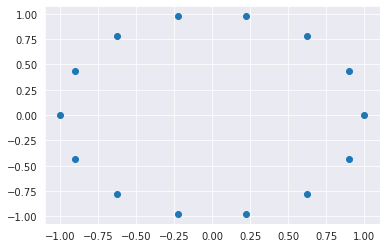

In [32]:
J=14
mf = sample_circle(J)
plt.scatter(mf[:,0], mf[:,1])

In [97]:
#spiral
J=28

a = 0.25
b = 0.25
thetas = jnp.linspace(0, 4*jnp.pi,J) #generates array of number from 0 to 2pi
xs = a*jnp.cos(thetas)*jnp.exp(b*thetas)
ys = a*jnp.sin(thetas)*jnp.exp(b*thetas)
mf = jnp.stack([xs,ys],axis=1)

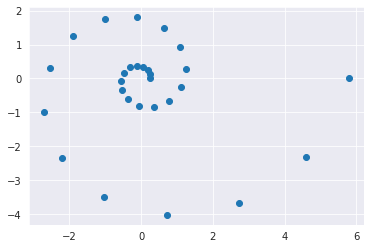

In [98]:
plt.scatter(mf[:,0], mf[:,1])

Forward part

In [33]:
beta_max=3
beta_min=0.001


def beta_t(t):
    return beta_min + t*(beta_max - beta_min)
def alpha_t(t):
    return t*beta_min + 0.5*(t**2)*(beta_max - beta_min)
def drift(x,t):
    return -0.5*beta_t(t)*x
def dispersion(t):
    return jnp.sqrt(beta_t(t))
def mean_factor(t):
    return jnp.exp(-0.5*alpha_t(t))
def var(t):
    return 1- jnp.exp(-alpha_t(t))

Monte carlo stuff with the marginals of the distribution

Stein score function

In [34]:
from jax.scipy.special import logsumexp

def log_hat_pt(x,t):
    N = mf.shape[0] #get number of observations
    """calculate transition kernel"""
    means = mf * mean_factor(t)
    v = var(t)
    #next bit comes from the inside of the normal distribution
    exponent = jnp.sum(-(x - means)**2 / (2 * v), axis=1)
    return logsumexp(exponent, axis =0, b=1/N) # b is the scaling factor for the exponential term

In [99]:
"""Get Stein score"""
nabla_log_hat_pt = jit(vmap(grad(log_hat_pt), in_axes=(0, 0), out_axes=(0)))

Plot vector field

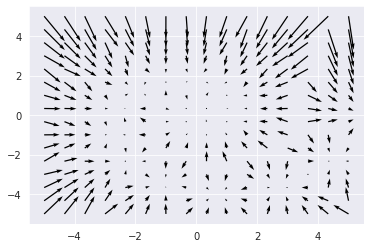

In [101]:
"""helper function"""

def plot_score(score, t, area_min=-1, area_max=1):
    #this helper function is here so that we can jit it.
    #We can not jit the whole function since plt.quiver cannot
    #be jitted
    @partial(jit, static_argnums=[0,])
    def helper(score, t, area_min, area_max):
        x = jnp.linspace(area_min, area_max, 16)
        x, y = jnp.meshgrid(x, x)
        grid = jnp.stack([x.flatten(), y.flatten()], axis=1)
        t = jnp.ones((grid.shape[0], 1)) * t
        scores = score(grid, t)
        return grid, scores
    grid, scores = helper(score, t, area_min, area_max)
    plt.quiver(grid[:, 0], grid[:, 1], scores[:, 0], scores[:, 1])

plot_score(nabla_log_hat_pt, 0.075, -5, 5)

Reverse direction

In [37]:
#time steps
R=1000
train_ts = jnp.arange(1, R)/(R-1)

In [38]:
@partial(jit, static_argnums=[1,2,3,4,5])
def reverse_sde(rng, N, n_samples, forward_drift, dispersion, score, ts=train_ts):
    """
    rng: random number generator (JAX rng)
    N: dimension in which the reverse SDE runs
    N_initial: How many samples from the initial distribution N(0, I), number
    forward_drift: drift function of the forward SDE (we implemented it above)
    disperion: dispersion function of the forward SDE (we implemented it above)
    score: The score function to use as additional drift in the reverse SDE
    ts: a discretization {t_i} of [0, T], shape 1d-array
    """
    def f(carry, params): #this function computes the next random variable along the reverse SDE trajectory
        t, dt = params
        x, rng = carry
        rng, step_rng = jr.split(rng)
        disp = dispersion(1-t)
        t = jnp.ones((x.shape[0], 1)) * t
        drift = -forward_drift(x, 1-t) + disp**2 * score(x, 1-t)
        noise = jr.normal(step_rng, x.shape)
        x = x + dt * drift + jnp.sqrt(dt)*disp*noise #EM scheme
        return (x, rng), ()
    
    rng, step_rng = jr.split(rng)
    initial = jr.normal(step_rng, (n_samples, N)) #this generates the standard Gaussian that we sample from in order to start the reverse process
    print(initial, initial.shape)
    dts = ts[1:] - ts[:-1]
    print(dts, dts.shape)
    print(ts[:-1])
    params = jnp.stack([ts[:-1], dts], axis=1)
    print(params, params.shape)
    (x, _), _ = scan(f, (initial, rng), params) #scan just iterates over a particular value whilst fixing a state - so here we fix (initial, rng) and apply function f on each element of params
    #why do we have the weird x thing - I think it is because scan outputs the fixed state/carry so to be able to extract x we need to output scan like this
    #(x, _), _ 
    return x

#params are just a stack (side by side) of the first column being the times and

In [39]:
#helper function

def plot_heatmap(positions, area_min=-2, area_max=2):
    """
    positions: locations of all particles in R^2, array (J, 2)
    area_min: lowest x and y coordinate
    area_max: highest x and y coordinate
    
    will plot a heatmap of all particles in the area [area_min, area_max] x [area_min, area_max]
    """
    def small_kernel(z, area_min, area_max):
        a = jnp.linspace(area_min, area_max, 512)
        x, y = jnp.meshgrid(a, a)
        dist = (x - z[0])**2 + (y - z[1])**2
        hm = jnp.exp(-350*dist)
        return hm

    #again we try to jit most of the code, but use the helper functions
    #since we cannot jit all of it because of the plt functions
    @jit
    def produce_heatmap(positions, area_min, area_max):
        return jnp.sum(vmap(small_kernel, in_axes=(0, None, None))(positions, area_min, area_max), axis=0)

    hm = produce_heatmap(positions, area_min, area_max) #np.sum(vmap(small_kernel)(to_plot), axis=0)
    extent = [area_min, area_max, area_max, area_min]
    plt.imshow(hm, cmap=cm, interpolation='nearest', extent=extent)
    ax = plt.gca()
    ax.invert_yaxis()

In [40]:
rng, step_rng = jr.split(rng)
samples = reverse_sde(step_rng, 2, 5000, drift, dispersion, nabla_log_hat_pt)
#plot_heatmap(samples[:, [0,1]], -3, 3)

Traced<ShapedArray(float32[5000,2])>with<DynamicJaxprTrace(level=0/1)> (5000, 2)
Traced<ShapedArray(float32[998])>with<DynamicJaxprTrace(level=0/1)> (998,)
Traced<ShapedArray(float32[998])>with<DynamicJaxprTrace(level=0/1)>
Traced<ShapedArray(float32[998,2])>with<DynamicJaxprTrace(level=0/1)> (998, 2)


In [41]:
samples = reverse_sde(step_rng, 2, 5000, drift, dispersion, nabla_log_hat_pt)

Bounded perturbation - basically add 1 to the score

In [102]:
perturbed_score = lambda x, t: nabla_log_hat_pt(x, t) + 1
rng, step_rng = jr.split(rng)
samples = reverse_sde(step_rng, 2, 5000, drift, dispersion, perturbed_score)
#plot_heatmap(samples[:, [0,1]], -3, 3)

Traced<ShapedArray(float32[5000,2])>with<DynamicJaxprTrace(level=0/1)> (5000, 2)
Traced<ShapedArray(float32[998])>with<DynamicJaxprTrace(level=0/1)> (998,)
Traced<ShapedArray(float32[998])>with<DynamicJaxprTrace(level=0/1)>
Traced<ShapedArray(float32[998,2])>with<DynamicJaxprTrace(level=0/1)> (998, 2)


Training

In [43]:
!pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import flax.linen as nn

class ApproximateScore(nn.Module):
    
    @nn.compact
    def __call__(self,x,t):
        in_size = x.shape[1]
        n_hidden = 256
        act = nn.relu
        t = jnp.concatenate([t-0.5, jnp.cos(2*jnp.pi*t)],axis=1)
        x=jnp.concatenate([x,t], axis=1)
        x = nn.Dense(n_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(n_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(n_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(in_size)(x)
        return x
        

Initialise

In [103]:
import optax

batch_size = 28

x = jnp.zeros(2*batch_size).reshape((batch_size, 2))
time = jnp.ones((batch_size, 1))

score_model = ApproximateScore()
params = score_model.init(rng, x, time)

optimiser = optax.adam(1e-3)
opt_state = optimiser.init(params)

Loss

In [46]:
def loss_fn(params, model, rng, batch):
  rng, step_rng = jr.split(rng)
  N_batch = batch.shape[0]
  t = jr.randint(step_rng, (N_batch,1), 1, R)/(R-1) #random uniform values
  mean_coeff = mean_factor(t)
  vs = var(t)
  stds = jnp.sqrt(vs)
  rng, step_rng = jr.split(rng)
  noise = jr.normal(step_rng, batch.shape)
  xt = batch * mean_coeff + noise *stds # here we only need the forward process so we calculate value
  output = score_model.apply(params, xt,t)
  loss = jnp.mean((noise + output*vs)**2) #weird noise loss from DDPMs
  return loss


Update_step

In [51]:
@partial(jit, static_argnums=[4])
def update_step(params, rng, batch, opt_state, model):
    val, grads = jax.value_and_grad(loss_fn)(params, model, rng, batch) #backprop step
    updates, opt_state = optimiser.update(grads, opt_state)# equivalent to SGD step
    params = optax.apply_updates(params, updates) #update network's parameters
    return val, params, opt_state

Training

In [108]:
N_epochs = 10_000
train_size = mf.shape[0]
batch_size = 5
batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size
for k in range(N_epochs):
    rng, step_rng = jr.split(rng)
    perms = jr.permutation(step_rng, train_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    losses = []
    for perm in perms:
        batch = mf[perm, :]
        rng, step_rng = jr.split(rng)
        loss, params, opt_state = update_step(params, step_rng, batch, opt_state, score_model)
        losses.append(loss)
    mean_loss = jnp.mean(jnp.array(losses))
    if k % 1000 == 0:
        print("Epoch %d \t, Loss %f " % (k, mean_loss))

Epoch 0 	, Loss 0.612704 
Epoch 1000 	, Loss 0.640568 
Epoch 2000 	, Loss 0.408529 
Epoch 3000 	, Loss 0.515167 
Epoch 4000 	, Loss 0.385057 
Epoch 5000 	, Loss 0.716800 
Epoch 6000 	, Loss 0.465480 
Epoch 7000 	, Loss 0.533514 
Epoch 8000 	, Loss 0.496508 
Epoch 9000 	, Loss 0.536309 


Results

Traced<ShapedArray(float32[1000,2])>with<DynamicJaxprTrace(level=0/1)> (1000, 2)
Traced<ShapedArray(float32[998])>with<DynamicJaxprTrace(level=0/1)> (998,)
Traced<ShapedArray(float32[998])>with<DynamicJaxprTrace(level=0/1)>
Traced<ShapedArray(float32[998,2])>with<DynamicJaxprTrace(level=0/1)> (998, 2)


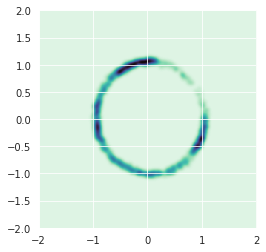

In [57]:
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = jr.split(rng)
samples = reverse_sde(step_rng, 2, 1000, drift, dispersion, trained_score)
plot_heatmap(samples)

Traced<ShapedArray(float32[1000,2])>with<DynamicJaxprTrace(level=0/1)> (1000, 2)
Traced<ShapedArray(float32[998])>with<DynamicJaxprTrace(level=0/1)> (998,)
Traced<ShapedArray(float32[998])>with<DynamicJaxprTrace(level=0/1)>
Traced<ShapedArray(float32[998,2])>with<DynamicJaxprTrace(level=0/1)> (998, 2)


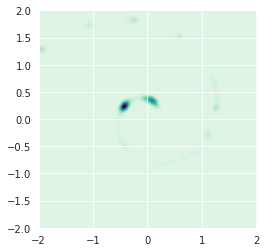

In [109]:
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = jr.split(rng)
samples = reverse_sde(step_rng, 2, 1000, drift, dispersion, trained_score)
plot_heatmap(samples)